In [2]:
# imports
import os, glob
import random
import xml.etree.ElementTree as ET
from dataclasses import dataclass
import pandas as pd

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [3]:
IMG_DIR = "img_data"
LABEL_DIR = "label_data"
# images = root.findall("image")

In [11]:
# xml_path = "label_data/ann_a23.xml"

# tree = ET.parse(xml_path)
# root = tree.getroot()
# images = root.findall("image")
# # print(root.tag)
# # list(root)[:5]
# # len(images
# tree

In [9]:
# images[0].attrib.get("name")

'left-side.jpg'

In [13]:
# img = images[0]

# print("Image name:", img.attrib.get("name"))
# print("Image id:", img.attrib.get("id"))

# for attr in img.findall("attribute"):
#     print(attr.attrib["name"], ":", attr.text)

Image name: left-side.jpg
Image id: 0


In [15]:
# [c.tag for c in list(images[0])[:20]]

['tag', 'tag', 'tag', 'tag', 'tag', 'tag', 'tag', 'tag', 'tag']

In [16]:
# for t in images[0].findall("tag"):
#     print("TAG:", t.attrib.get("label"))
#     for a in t.findall("attribute"):
#         print("  ", a.attrib.get("name"), "=", (a.text or "").strip())

TAG: Dryness
   Severity = None
TAG: DarkCircles
   Severity = None
TAG: Wrinkles
   Severity = Mild
TAG: Texture
   Severity = Mild
TAG: Scarring
   Severity = Mild
TAG: Pose
   view = Three_quarters_L
TAG: Acne
   Severity = None
TAG: Redness
   Severity = None
TAG: Pigmentation
   Severity = Mild


In [17]:
# record = {"filename": images[0].attrib["name"]}

# for t in images[0].findall("tag"):
#     label = t.attrib["label"]          # e.g., "Acne"
#     attr = t.findall("attribute")[0]   # first (and only) attribute
#     record[label] = (attr.text or "").strip()

# record

{'filename': 'left-side.jpg',
 'Dryness': 'None',
 'DarkCircles': 'None',
 'Wrinkles': 'Mild',
 'Texture': 'Mild',
 'Scarring': 'Mild',
 'Pose': 'Three_quarters_L',
 'Acne': 'None',
 'Redness': 'None',
 'Pigmentation': 'Mild'}

## GENERATING DATAFRAME + PREREQS FOR MODEL

In [4]:
# develop a dataframe taken from xml file
'''
<annotations>            ← ROOT (grandparent)
   <image>               ← child
      <tag>              ← grandchild
         <attribute>     ← great-grandchild

generate family tree for all xml_files
-> then find all images associated with each tree, then develop df
input: xml_files - list of all paths to xml files 
output: dataframe
'''
def create_df(xml_files):
    rows = []
    for xml_path in xml_files:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        images = root.findall("image")
    
        for img in images:
            row = {"filename": img.attrib["name"]}
            for t in img.findall("tag"):
                label = t.attrib["label"]
                attr = t.findall("attribute")[0]
                row[label] = (attr.text).strip()
            rows.append(row)
    
    df = pd.DataFrame(rows).replace({np.nan: 'None'})
    return df

In [5]:
# filename matching, gather all xml files, generate df
xml_files = glob.glob("label_data/*.xml")
df = create_df(xml_files)
df.head()

,filename,Acne,Redness,Pigmentation,Dryness,DarkCircles,Wrinkles,Texture,Scarring,Pose
0,levle0_1.jpg,Mild,Mild,Mild,None,Mild,None,Mild,Mild,Three_quarters_R
1,levle0_100.jpg,Mild,Mild,Mild,Severe,Moderate,None,Mild,Mild,Three_quarters_L
2,levle0_105.jpg,Mild,Mild,Mild,Severe,Moderate,None,Mild,None,Three_quarters_L
3,levle0_107.jpg,Mild,Mild,Mild,Mild,None,None,Mild,None,Three_quarters_R
4,levle0_114.jpg,Moderate,Moderate,Moderate,None,None,None,Severe,Severe,Three_quarters_R


In [6]:
# I think the best approaching a model first is by making each attribute binary: JUST FOR NOW.
# None = 0, every other severity = 1
LABEL_COLS = df.columns
df_bin = df.copy()

for c in df.columns:
    df_bin[c] = (df_bin[c] != "None").astype(int)
df_bin["filename"] = df["filename"]
df_bin[LABEL_COLS].head()

,filename,Acne,Redness,Pigmentation,Dryness,DarkCircles,Wrinkles,Texture,Scarring,Pose
0,levle0_1.jpg,1,1,1,0,1,0,1,1,1
1,levle0_100.jpg,1,1,1,1,1,0,1,1,1
2,levle0_105.jpg,1,1,1,1,1,0,1,0,1
3,levle0_107.jpg,1,1,1,1,0,0,1,0,1
4,levle0_114.jpg,1,1,1,0,0,0,1,1,1


In [7]:
LABEL_COLS = df.columns[:-1]

In [8]:
# checking label balance
# pos_counts = df_bin[LABEL_COLS].sum().sort_values(ascending=False)
# pos_rate = (pos_counts / len(df_bin)).round(3)

# pos_counts, pos_rate

In [9]:
# weights that we are going to use for BCE Loss for our model
# we are using this because our labels are quite imbalanced
pos = df_bin[LABEL_COLS[1:]].sum()
neg = len(df_bin) - pos

pos_weight = neg / pos

pos_weight

Acne            0.141509
Redness         0.216080
Pigmentation    0.130841
Dryness         0.890625
DarkCircles     0.440476
Wrinkles        1.987654
Texture         0.146919
Scarring        0.174757
dtype: float64

## BEGIN TRAINING MODEL

In [10]:
train_df, val_df = train_test_split(df_bin, test_size=0.2, random_state=42, shuffle=True)
len(train_df), len(val_df)

(193, 49)

In [11]:
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class SkinDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(IMG_DIR, row["filename"])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        y = torch.tensor(row[LABEL_COLS[1:]].to_numpy(dtype="float32"), dtype=torch.float32)
        return img, y

In [26]:
train_loader = DataLoader(SkinDataset(train_df, train_tf), batch_size=8, shuffle=True)
# x, y = next(iter(train_loader))

# x.shape, y.shape, y[0]
val_loader = DataLoader(SkinDataset(val_df, val_tf), batch_size=8, shuffle=False)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(LABEL_COLS)-1)  # 8 outputs
model = model.to(device)

# model

In [17]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

C:\Users\antho\AppData\Local\Temp\ipykernel_26404\2899741748.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))


In [16]:
# one batch test to see if everything is working
# model.train()
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)

# logits = model(x)                 # (batch, 8)
# loss = criterion(logits, y)

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

# logits.shape, loss.item()

In [30]:
for name, p in model.named_parameters():
    p.requires_grad = name.startswith("fc.")

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

for epoch in range(3):
    model.train()
    total_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"epoch {epoch+1}: train_loss={avg_loss:.4f}")

epoch 1: train_loss=0.3704
epoch 2: train_loss=0.3535
epoch 3: train_loss=0.3372


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score

def freeze_backbone_train_head_only(model):
    # Freeze everything
    for p in model.parameters():
        p.requires_grad = False
    # Unfreeze head (ResNet uses model.fc)
    for p in model.fc.parameters():
        p.requires_grad = True
    return model

@torch.no_grad()
def evaluate_multilabel(model, loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    n_samples = 0

    all_logits = []
    all_targets = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        n_samples += bs

        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())

    avg_loss = total_loss / max(n_samples, 1)

    logits = torch.cat(all_logits, dim=0).numpy()
    targets = torch.cat(all_targets, dim=0).numpy()

    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= threshold).astype(np.int32)

    # F1 metrics
    f1_micro = f1_score(targets, preds, average="micro", zero_division=0)
    f1_macro = f1_score(targets, preds, average="macro", zero_division=0)

    # AUROC (can fail if a label has only 0s or only 1s in this split)
    auroc_macro = None
    try:
        auroc_macro = roc_auc_score(targets, probs, average="macro")
    except ValueError:
        pass

    return {
        "loss": avg_loss,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "auroc_macro": auroc_macro
    }

def train_head_only(
    model,
    train_loader,
    val_loader,
    criterion,
    device,
    head_epochs=5,
    lr=1e-3,
    threshold=0.5,
):
    model = freeze_backbone_train_head_only(model).to(device)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

    history = {
        "train_loss": [], "val_loss": [],
        "train_f1_micro": [], "val_f1_micro": [],
        "train_f1_macro": [], "val_f1_macro": [],
        "train_auroc_macro": [], "val_auroc_macro": [],
    }

    for epoch in range(1, head_epochs + 1):
        model.train()
        total_loss = 0.0
        n_samples = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = x.size(0)
            total_loss += loss.item() * bs
            n_samples += bs

        train_loss = total_loss / max(n_samples, 1)

        # Metrics on full train/val splits
        train_metrics = evaluate_multilabel(model, train_loader, criterion, device, threshold)
        val_metrics = evaluate_multilabel(model, val_loader, criterion, device, threshold) if val_loader is not None else None

        history["train_loss"].append(train_metrics["loss"])
        history["train_f1_micro"].append(train_metrics["f1_micro"])
        history["train_f1_macro"].append(train_metrics["f1_macro"])
        history["train_auroc_macro"].append(train_metrics["auroc_macro"])

        if val_metrics is not None:
            history["val_loss"].append(val_metrics["loss"])
            history["val_f1_micro"].append(val_metrics["f1_micro"])
            history["val_f1_macro"].append(val_metrics["f1_macro"])
            history["val_auroc_macro"].append(val_metrics["auroc_macro"])

            print(
                f"Epoch {epoch:02d} | "
                f"train loss {train_metrics['loss']:.4f} f1µ {train_metrics['f1_micro']:.4f} f1M {train_metrics['f1_macro']:.4f} "
                f"| val loss {val_metrics['loss']:.4f} f1µ {val_metrics['f1_micro']:.4f} f1M {val_metrics['f1_macro']:.4f} "
                f"| val AUROC(M) {('%.4f' % val_metrics['auroc_macro']) if val_metrics['auroc_macro'] is not None else 'n/a'}"
            )
        else:
            print(
                f"Epoch {epoch:02d} | "
                f"train loss {train_metrics['loss']:.4f} f1µ {train_metrics['f1_micro']:.4f} f1M {train_metrics['f1_macro']:.4f}"
            )

    return model, history

def plot_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train")
    if len(history["val_loss"]) > 0:
        plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # F1 micro
    plt.figure()
    plt.plot(epochs, history["train_f1_micro"], label="train")
    if len(history["val_f1_micro"]) > 0:
        plt.plot(epochs, history["val_f1_micro"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("F1 (micro)")
    plt.title("F1 Micro")
    plt.legend()
    plt.show()

    # F1 macro
    plt.figure()
    plt.plot(epochs, history["train_f1_macro"], label="train")
    if len(history["val_f1_macro"]) > 0:
        plt.plot(epochs, history["val_f1_macro"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("F1 (macro)")
    plt.title("F1 Macro")
    plt.legend()
    plt.show()

    # AUROC macro (optional)
    if any(v is not None for v in history["train_auroc_macro"]) or any(v is not None for v in history["val_auroc_macro"]):
        plt.figure()
        train_auc = [v if v is not None else np.nan for v in history["train_auroc_macro"]]
        plt.plot(epochs, train_auc, label="train")
        if len(history["val_auroc_macro"]) > 0:
            val_auc = [v if v is not None else np.nan for v in history["val_auroc_macro"]]
            plt.plot(epochs, val_auc, label="val")
        plt.xlabel("Epoch")
        plt.ylabel("AUROC (macro)")
        plt.title("AUROC Macro")
        plt.legend()
        plt.show()

# ---- Example usage ----
# model, history = train_head_only(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     device=device,
#     head_epochs=5,
#     lr=1e-3,
#     threshold=0.5,
# )
# plot_history(history)

In [31]:
model.fc.reset_parameters()

In [32]:
model, history = train_head_only(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,   # IMPORTANT: yes, use validation
    criterion=criterion,
    device=device,
    head_epochs=20,           # you can change this (e.g. 3–10)
    lr=1e-3,                 # higher LR for head-only training
    threshold=0.35
)

Epoch 01 | train loss 0.3856 f1µ 0.7606 f1M 0.7094 | val loss 0.4078 f1µ 0.6752 f1M 0.6236 | val AUROC(M) 0.6353
Epoch 02 | train loss 0.3440 f1µ 0.8173 f1M 0.8035 | val loss 0.3756 f1µ 0.7667 f1M 0.7535 | val AUROC(M) 0.6864
Epoch 03 | train loss 0.3286 f1µ 0.8637 f1M 0.8440 | val loss 0.4086 f1µ 0.8192 f1M 0.8038 | val AUROC(M) 0.7099
Epoch 04 | train loss 0.3124 f1µ 0.8663 f1M 0.8481 | val loss 0.3677 f1µ 0.8198 f1M 0.8059 | val AUROC(M) 0.7259
Epoch 05 | train loss 0.3095 f1µ 0.8812 f1M 0.8533 | val loss 0.3790 f1µ 0.8183 f1M 0.7860 | val AUROC(M) 0.7510
Epoch 06 | train loss 0.3012 f1µ 0.8718 f1M 0.8543 | val loss 0.3866 f1µ 0.8210 f1M 0.8077 | val AUROC(M) 0.7525
Epoch 07 | train loss 0.2852 f1µ 0.8770 f1M 0.8595 | val loss 0.3737 f1µ 0.8294 f1M 0.8164 | val AUROC(M) 0.7586
Epoch 08 | train loss 0.2769 f1µ 0.8917 f1M 0.8741 | val loss 0.3589 f1µ 0.8344 f1M 0.8191 | val AUROC(M) 0.7678
Epoch 09 | train loss 0.2675 f1µ 0.8884 f1M 0.8694 | val loss 0.3829 f1µ 0.8255 f1M 0.8115 | val

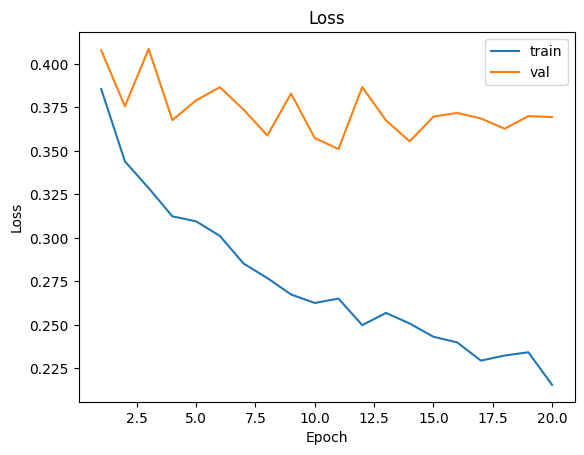

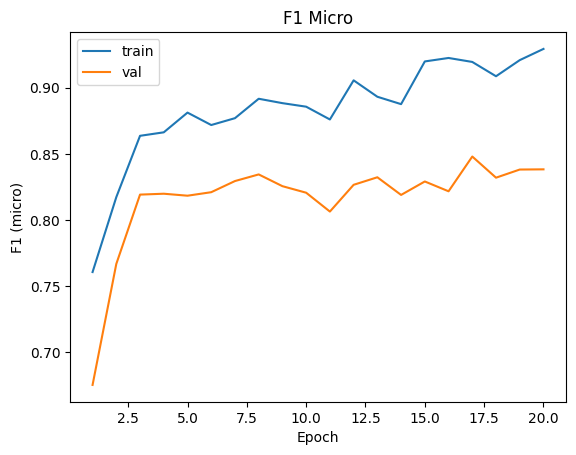

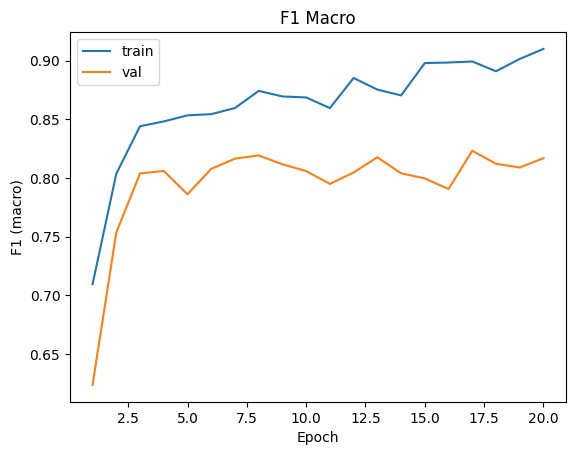

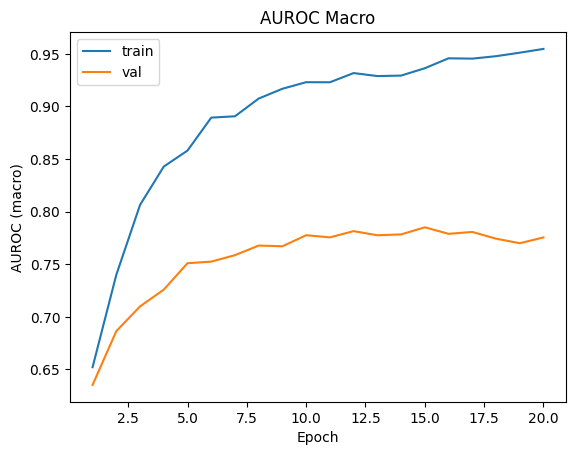

In [34]:
plot_history(history)

In [33]:
def find_best_threshold(model, val_loader, device, criterion):
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())
    logits = torch.cat(all_logits).numpy()
    targets = torch.cat(all_targets).numpy()
    probs = 1 / (1 + np.exp(-logits))

    best_t, best_f1 = None, -1
    for t in np.linspace(0.05, 0.95, 19):
        preds = (probs >= t).astype(int)
        f1 = f1_score(targets, preds, average="micro", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

best_t, best_f1 = find_best_threshold(model, val_loader, device, criterion)
best_t, best_f1

(np.float64(0.39999999999999997), np.float64(0.8457538994800693))